In [1]:
pip install tensorflow


Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [3]:
# MODULE USED
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [4]:
# VARIABLE USED
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=54

In [5]:
# LOADING OF DATASET
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "Handwritings",
shuffle=True,
image_size=(IMAGE_SIZE,IMAGE_SIZE),
batch_size=BATCH_SIZE
)

Found 4500 files belonging to 3 classes.


In [6]:
#  CLASS NAMES IN WHICH OUR DATASET IS DIVIDED
class_names=dataset.class_names
class_names

['Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_healthy']

In [7]:
len(dataset)

141

(32, 256, 256, 3)
[0 2 1 1 2 2 2 2 0 1 1 1 0 2 2 2 2 2 1 1 0 0 2 1 0 0 1 1 1 2 1 2]


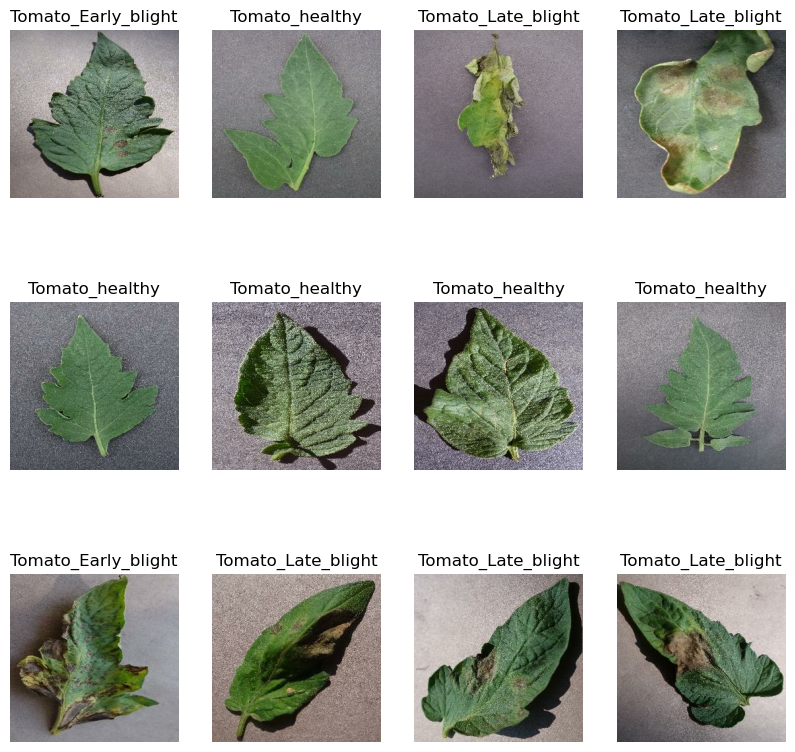

In [8]:
# LABELING IMAGES AND PRINTING THEM
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [9]:
# TRAINING OF OUR DATA
train_size=0.8
len(dataset)*train_size

112.80000000000001

In [10]:
# PROVIDING 54 BATCHES FOR TRAINING
train_ds=dataset.take(54)

In [11]:
# PROVIDING REMAINING 10% DATA FOR TRAINING I.E. 6 BATCHES

test_ds=dataset.skip(54)
len(test_ds)

87

In [12]:
val_size=0.1
len(dataset)*val_size

14.100000000000001

In [13]:
val_ds=test_ds.take(6)
len(val_ds)

6

In [14]:
test_ds=test_ds.skip(6)
len(test_ds)

81

In [15]:
# USER DEFINE FUNCTION FOR PROVIND DATA FOR TRAINING , TESTING , VALIDATION
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1,shuffle=True,shuffle_size=10000):
    assert(train_split+test_split+val_split)==1
    
    ds_size=len(ds)
    
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
        
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds,val_ds,test_ds

In [16]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [17]:
len(train_ds)

112

In [18]:
len(val_ds)

14

In [19]:
len(test_ds)

15

In [20]:
# TRAINING TESTING VALIDATION IMPLEMENTATION

train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
#  NORMALISATION OF DATA AND CONVERTING THEM INTO 0 AND 1

resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),

    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [22]:
# DATA AUGMENTATION 

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])


In [23]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

In [24]:
model.build(input_shape=input_shape)

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [26]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [27]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/54
112/112 [==============================] - 133s 1s/step - loss: 0.9163 - accuracy: 0.5484 - val_loss: 1.1232 - val_accuracy: 0.5759
Epoch 2/54
112/112 [==============================] - 124s 1s/step - loss: 0.5524 - accuracy: 0.7464 - val_loss: 0.7058 - val_accuracy: 0.6808
Epoch 3/54
112/112 [==============================] - 123s 1s/step - loss: 0.4959 - accuracy: 0.7814 - val_loss: 0.5894 - val_accuracy: 0.7388
Epoch 4/54
112/112 [==============================] - 124s 1s/step - loss: 0.4001 - accuracy: 0.8236 - val_loss: 0.8473 - val_accuracy: 0.7076
Epoch 5/54
112/112 [==============================] - 123s 1s/step - loss: 0.3692 - accuracy: 0.8401 - val_loss: 0.6558 - val_accuracy: 0.7344
Epoch 6/54
112/112 [==============================] - 124s 1s/step - loss: 0.3079 - accuracy: 0.8751 - val_loss: 0.2435 - val_accuracy: 0.8929
Epoch 7/54
112/112 [==============================] - 124s 1s/step - loss: 0.3486 - accuracy: 0.8569 - val_loss: 0.2600 - val_accuracy: 0.8817

In [28]:
scores=model.evaluate(test_ds)
print(scores)

15/15 [==============================] - 7s 294ms/step - loss: 0.0601 - accuracy: 0.9729
[0.06014850363135338, 0.9729166626930237]


In [29]:
history

In [30]:
history.params

{'verbose': 1, 'epochs': 54, 'steps': 112}

In [31]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [32]:
history.history['accuracy']

[0.5484322309494019,
 0.7463605999946594,
 0.7813549637794495,
 0.8236282467842102,
 0.8401455879211426,
 0.8751399517059326,
 0.856942892074585,
 0.878779411315918,
 0.8812990188598633,
 0.8989361524581909,
 0.899776041507721,
 0.9092944860458374,
 0.9162933826446533,
 0.9232922792434692,
 0.9118140935897827,
 0.9314109683036804,
 0.9339305758476257,
 0.936450183391571,
 0.9342105388641357,
 0.9398096203804016,
 0.9448488354682922,
 0.9412094354629517,
 0.9479283094406128,
 0.9476484060287476,
 0.956606924533844,
 0.9445688724517822,
 0.9599664211273193,
 0.936170220375061,
 0.9554871320724487,
 0.9658454656600952,
 0.9599664211273193,
 0.9504479169845581,
 0.9608062505722046,
 0.9686450362205505,
 0.957726776599884,
 0.9624860286712646,
 0.9731243252754211,
 0.9616461396217346,
 0.978723406791687,
 0.9680851101875305,
 0.9725643992424011,
 0.9599664211273193,
 0.9708846807479858,
 0.977883517742157,
 0.9664053916931152,
 0.9767637252807617,
 0.9700447916984558,
 0.9798431992530823,
 

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

In [34]:
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

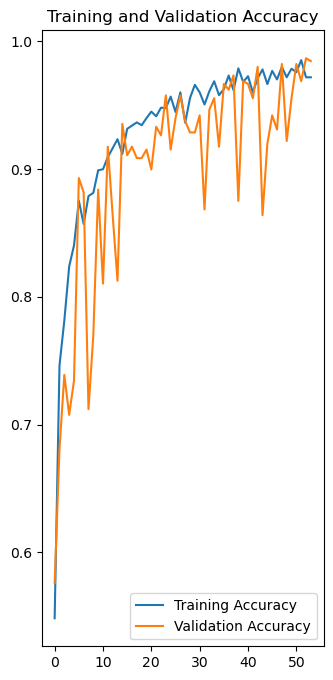

In [35]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

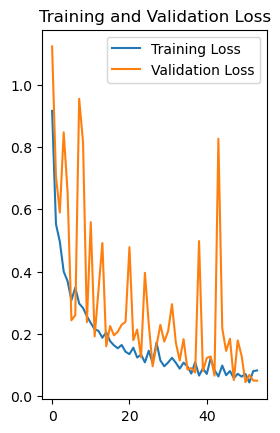

In [36]:
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Tomato_Late_blight
1/1 [==============================] - 1s 840ms/step
predicted label: Tomato_Late_blight


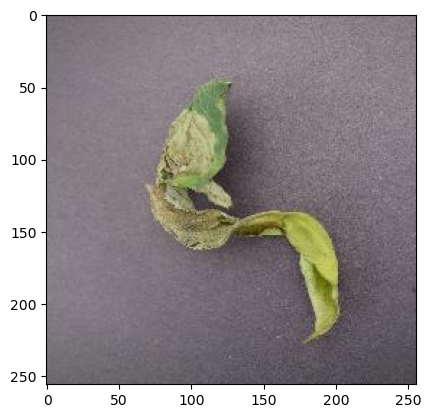

In [37]:
# HERE WE CAN CHECK OUR PREDICTION NY EXECUTING THIS CELL
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [38]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 55ms/step


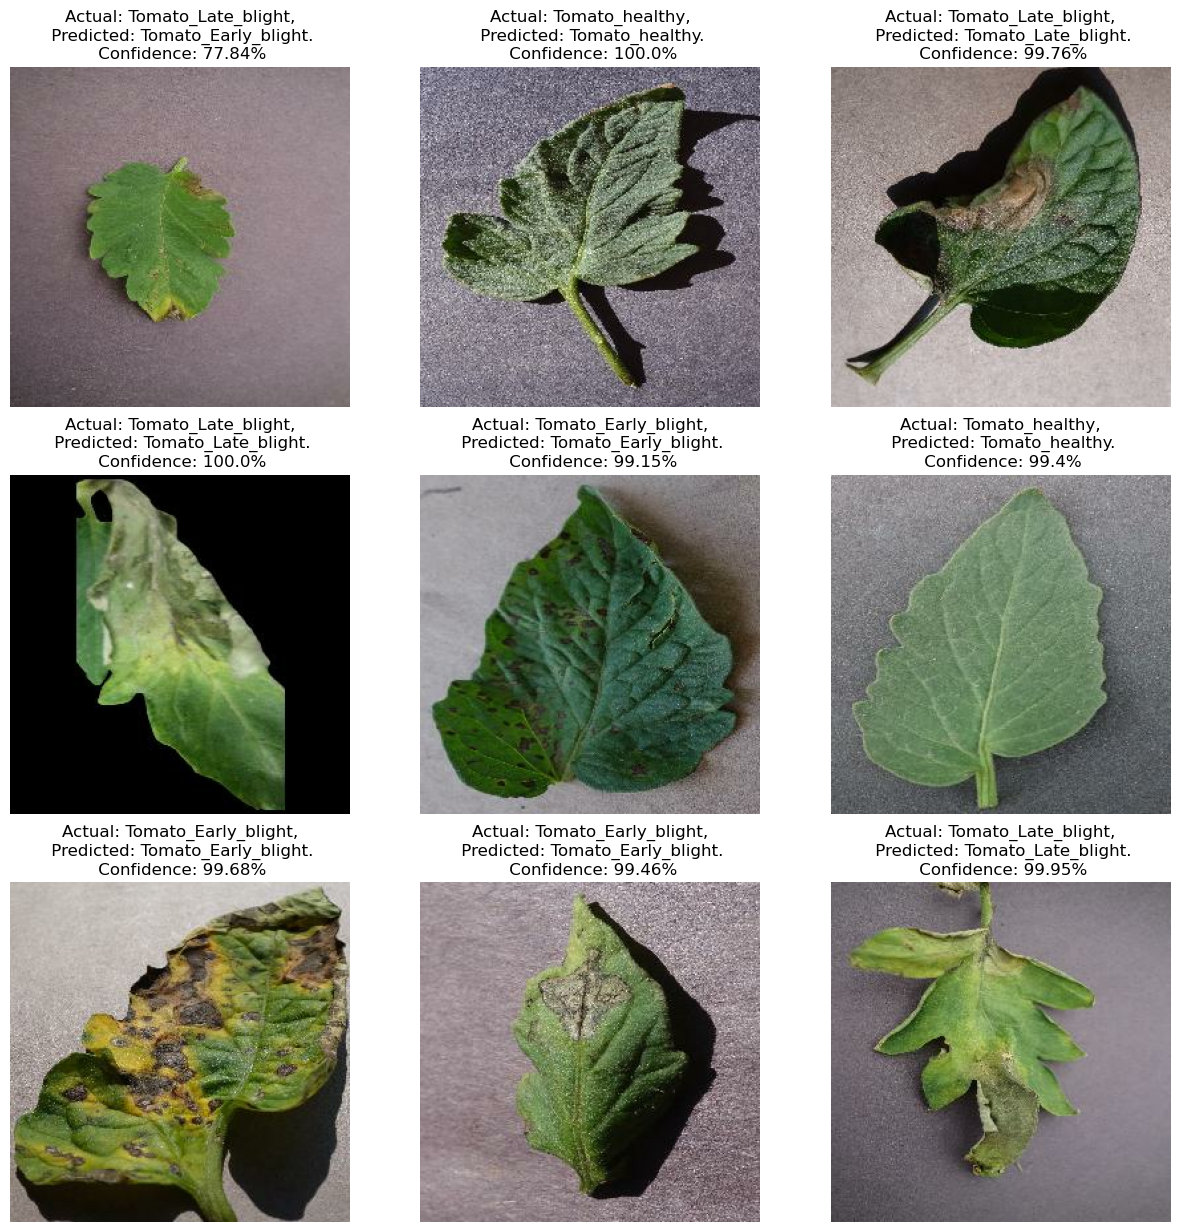

In [39]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [42]:
import os
model_version=max([int(i) for i in os.listdir("TomatoDisease/model") + [0]])+1
model.save(f"TomatoDisease/model/{model_version}")

INFO:tensorflow:Assets written to: TomatoDisease/model/1\assets


INFO:tensorflow:Assets written to: TomatoDisease/model/1\assets


In [43]:
pip install dash

                                              0.0/10.4 MB ? eta -:--:--
                                              0.0/10.4 MB ? eta -:--:--
                                              0.0/10.4 MB ? eta -:--:--
                                             0.0/10.4 MB 330.3 kB/s eta 0:00:32
                                             0.0/10.4 MB 330.3 kB/s eta 0:00:32
                                             0.1/10.4 MB 516.7 kB/s eta 0:00:20
                                             0.2/10.4 MB 579.6 kB/s eta 0:00:18
                                             0.2/10.4 MB 579.6 kB/s eta 0:00:18
                                             0.2/10.4 MB 456.4 kB/s eta 0:00:23
                                             0.2/10.4 MB 529.7 kB/s eta 0:00:20
                                             0.3/10.4 MB 562.4 kB/s eta 0:00:18
     -                                       0.3/10.4 MB 593.9 kB/s eta 0:00:17
     -                                       0.4/10.4 MB 656.4 k

In [44]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [70]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.express as px
import base64
from io import BytesIO
import numpy as np

In [71]:
model_path = "TomatoDisease/model/1"
model = tf.keras.models.load_model(model_path)

In [72]:
app = dash.Dash(__name__)
app.title = "tomato_D_star3"

In [73]:
app.layout = html.Div([
    html.H1("Tomato Disease Detection Dashboard"),

    dcc.Upload(
        id='upload-image',
        children=html.Div([
            'Drag and Drop or ',
            html.A('Select a File')
        ]),
        style={
            'width': '50%',
            'height': '60px',
            'lineHeight': '60px',
            'borderWidth': '1px',
            'borderStyle': 'dashed',
            'borderRadius': '5px',
            'textAlign': 'center',
            'margin': '10px auto'
        },
        multiple=False
    ),
    
    html.Div(id='output-image'),
    # Add a placeholder for the link to cure the disease
    html.Div(id='cure-link'),
])

In [1]:
curing_links = {
    'Tomato_Early_blight': 'https://content.ces.ncsu.edu/early-blight-of-tomato',
    'Tomato_Late_blight': 'https://content.ces.ncsu.edu/tomato-late-blight',
}
# Create a callback function to process the uploaded image and update the layout
@app.callback(Output('output-image', 'children'), Output('cure-link', 'children'),
              Input('upload-image', 'contents'))
def process_uploaded_image(contents):
    if contents is not None:
        content_type, content_string = contents.split(',')
        image_data = base64.b64decode(content_string)

        # Load and preprocess the uploaded image
        image = tf.image.decode_image(image_data)
        image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
        image = tf.image.convert_image_dtype(image, tf.float32)
        image = tf.expand_dims(image, axis=0)  # Add batch dimension

        # Use your model to make predictions
        predictions = model.predict(image)
        predicted_class = class_names[np.argmax(predictions[0])]

        # Set the detection result
        global detection_result
        detection_result = f"Predicted Class: {predicted_class}"

        # Get the curing link based on the predicted class, only for Early Blight and Late Blight
        link = curing_links.get(predicted_class, None)

        # Create an HTML element to display the uploaded image and prediction
        image_element = html.Div([
            html.Img(src='data:image/png;base64,{}'.format(base64.b64encode(image_data).decode())),
            html.H3(detection_result)
        ])

        # Set the link for curing the disease
        cure_link = None
        if link:
            cure_link = html.A('Cure Tomato Disease', href=link, target='_blank')

        # Return the image element and the link to cure the disease
        return [image_element, cure_link]

    else:
        return [None, None]

NameError: name 'app' is not defined

In [75]:
if __name__ == '__main__':
    app.run_server(debug=True)

1/1 [==============================] - 0s 70ms/step
